In [1]:
# cuda py-pytorch/1.4.0_py36 py-scipystack/1.0_py36 system x11
!nvidia-smi

Tue Jan  5 01:21:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:40:00.0 Off |                    0 |
| N/A   32C    P0    41W / 250W |      0MiB / 32510MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import torch
print(torch.cuda.get_device_name(0))
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
# !pip install torchsummary
# !pip install opencv-python==4.2.0.32
from torchsummary import summary
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import time
import cv2 as cv

Tesla V100-PCIE-32GB


In [3]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.6.1 (default, Apr 27 2017, 10:57:56) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-11)]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Apr_24_19:10:27_PDT_2019
Cuda compilation tools, release 10.1, V10.1.168
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [4]:
class DRDataset(Dataset):
    def __init__(self, csv_path):
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = '/scratch/groups/rubin/rvignav/input/train/' + self.image_arr[index] + '.jpeg'
        img_as_img = Image.open(single_image_name)
        img_as_img = img_as_img.resize((400,300))
        
        gamma = 1.3
        lookUpTable = np.empty((1,256), np.uint8)
        for i in range(256):
            lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        img_as_img = cv.LUT(np.uint8(img_as_img), lookUpTable)

        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [5]:
full_dataset = DRDataset('/scratch/groups/rubin/rvignav/input/train/trainLabels.csv')

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset)) 
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, 
                                                                         [train_size, val_size, test_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=True)
# print(len(train_loader.dataset))
# print(len(val_loader.dataset))
# print(len(test_loader.dataset))

In [6]:
"""
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR
"""
classes = ('none', 'mild', 'moderate', 'severe', 'proliferative')

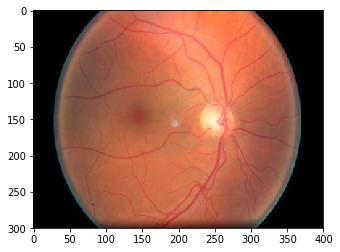

0: none


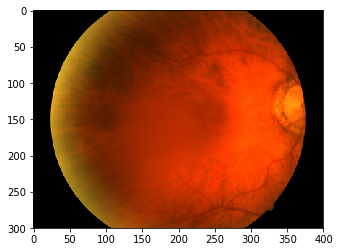

0: none


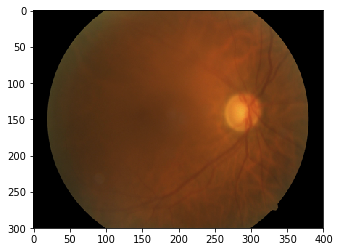

0: none


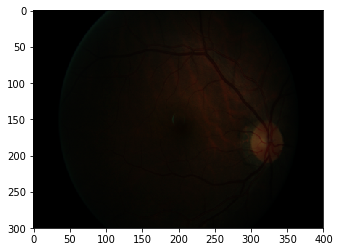

0: none


In [7]:
for data, target in train_loader:
    for i in range(0, 4):  
        im = data[i]
        im = torch.squeeze(im)
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray')
        plt.show()
        print(target[i] + ": " + classes[(int)(target[i])])
    break

In [8]:
# https://amaarora.github.io/2020/06/29/FocalLoss.html
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
#         self = self.cuda()
        targets = targets.unsqueeze(1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long).cuda()
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [9]:
# https://towardsdatascience.com/cuda-error-device-side-assert-triggered-c6ae1c8fa4c3
network = torchvision.models.vgg16() 
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #WeightedFocalLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.005, momentum=0.5, weight_decay=1e-4)

In [10]:
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 512)),
                           ('relu', nn.ReLU()), 
                           ('dropout', nn.Dropout(p=0.337)),
                           ('fc2', nn.Linear(512, 5)),
                           ('output', nn.LogSoftmax(dim=1))
                             ]))

network.classifier = classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network.to(device)

network = network.cuda()
network = torch.nn.DataParallel(network, device_ids=[0])

summary(network, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train(model, loader, criterion):
    model.train()
    current_loss = 0
    current_correct = 0
    bnum = 0
    print(str(len(iter(loader))) + " total steps")
    for train, t in iter(loader):
        bnum += 1
        print("Step ", bnum)
        y_train = np.zeros(len(t))
        for i in range(len(t)):
            y_train[i] = int(t[i])
        y_train = torch.from_numpy(y_train).float() #type(torch.int64)
        optimizer.zero_grad()
        output = model.forward(train.cuda())
        _, preds = torch.max(output,1)
#         print(output)
#         print(y_train)
#         print(torch.argmax(output, dim=1).float().cuda().dtype)
#         print(torch.argmax(output, dim=1).float().cuda().shape)
#         print(y_train.cuda().dtype)
#         print(y_train.cuda().shape)
#         ch = torch.unsqueeze(torch.argmax(output, dim=1), 1).float().cuda()
#         print(ch.is_cuda)
#         ch = y_train.cuda()
#         print(ch.is_cuda)
#         loss = criterion(torch.unsqueeze(torch.argmax(output, dim=1), 1).type(torch.int64).cuda(), 
#                          y_train.cuda()) #.float()
        loss = criterion(torch.argmax(output, dim=1).float().cuda(), y_train.cuda()) #long()
        loss = Variable(loss, requires_grad = True)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds.cuda() == y_train.data.cuda())
    epoch_loss = current_loss / len(train_loader.dataset)
    epoch_acc = current_correct.double() / len(train_loader.dataset)
#     torch.cuda.empty_cache()
    return epoch_loss, epoch_acc

In [ ]:
def validation(model, loader, criterion):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, t in iter(loader):
        y_valid = np.zeros(len(t))
        for i in range(len(t)):
            y_valid[i] = int(t[i])
        y_valid = torch.from_numpy(y_valid).long()
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(val_loader.dataset)
    epoch_acc = valid_correct.double() / len(val_loader.dataset)
    
    return epoch_loss, epoch_acc

In [ ]:
for param in network.parameters():
    param.require_grad = False

epochs = 20  
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(network,train_loader, criterion)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    if e % 5 == 0:
        torch.save(network.state_dict(), '/scratch/groups/rubin/checkpoint_' + str(e // 5) + '.pth')
with torch.no_grad():
    epoch_val_loss, epoch_val_acc = validation(network, val_loader, criterion)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
3513 total steps
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
Step  10
Step  11
Step  12
Step  13
Step  14
Step  15
Step  16
Step  17
Step  18
Step  19
Step  20
Step  21
Step  22
Step  23
Step  24
Step  25
Step  26
Step  27
Step  28
Step  29
Step  30
Step  31
Step  32
Step  33
Step  34
Step  35
Step  36
Step  37
Step  38
Step  39
Step  40
Step  41
Step  42
Step  43
Step  44
Step  45
Step  46
Step  47
Step  48
Step  49
Step  50
Step  51
Step  52
Step  53
Step  54
Step  55
Step  56
Step  57
Step  58
Step  59
Step  60
Step  61
Step  62
Step  63
Step  64
Step  65
Step  66
Step  67
Step  68
Step  69
Step  70
Step  71
Step  72
Step  73
Step  74
Step  75
Step  76
Step  77
Step  78
Step  79
Step  80
Step  81
Step  82
Step  83
Step  84
Step  85
Step  86
Step  87
Step  88
Step  89
Step  90
Step  91
Step  92
Step  93
Step  94
Step  95
Step  96
Step  97
Step  98
Step  99
Step  100
Step  101
Step  102
Step  103
Step  104
Step  105
Step  106
Step  107
Step  108
Step  109

In [ ]:
network.eval()
total = 0
correct = 0 
count = 0

for test, t in iter(test_loader):
    y_test = np.zeros(len(t))
    for i in range(len(t)):
        y_test[i] = int(t[i])
    y_test = torch.from_numpy(y_test)
    with torch.no_grad():
        output = network.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1

print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

In [ ]:
torch.save(network.state_dict(), '/scratch/groups/rubin/dr_not_stylized.pth')

In [ ]:
for data, target in val_loader:
    outputs = network(data)
    _, predicted = torch.max(outputs, 1)
    for i in range(0, 4):  
        im = data[i]
        im = torch.squeeze(im)
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
        plt.show()
        print("TARGET-- " + target[i] + ": " + classes[(int)(target[i])])
        # print(predicted[i].numpy())
        print("PREDICTION-- " + str(predicted[i].numpy()) + ": " + classes[predicted[i].numpy()])
    break